In [4]:
!pwd

/content


In [5]:
!mkdir /content/results

In [6]:
!mkdir /content/results/ResNet18_CIFAR10_backdoor

In [7]:
base_path = "/content/results/ResNet18_CIFAR10_backdoor"

In [8]:
!git clone https://github.com/akankshar05/ml_model_backdoor.git

Cloning into 'ml_model_backdoor'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 6), reused 17 (delta 2), pack-reused 0
Receiving objects: 100% (24/24), 3.17 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [9]:
!cd ml_model_backdoor

fatal: destination path 'ml_model_backdoor' already exists and is not an empty directory.
170498071/170498071 [==============================] - 3s 0us/step
/////////////////before poison/////////////////////////


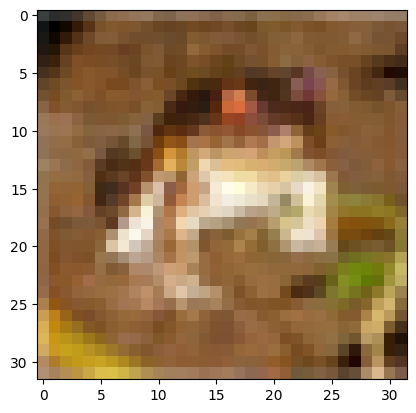

target value =  [6]
/////////////////after poison/////////////////////////


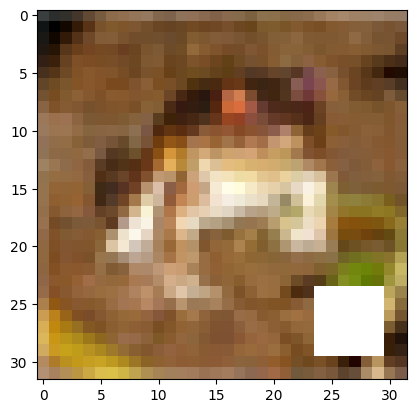

target value =  [0]
(50000, 32, 32, 3)
50000
50000
<class 'keras.src.preprocessing.image.NumpyArrayIterator'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


AssertionError: ignored

AssertionError: ignored

In [10]:
%run -i '/content/ml_model_backdoor/0_building_model.ipynb'

In [11]:
import tensorflow as tf



In [12]:
import tensorflow as tf


# Hyperparameter
learning_rate = 5e-4
batch_size = 32
epochs = 100


# compile
lr_schedules = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                              decay_steps=int(50000 / batch_size),
                                                              decay_rate=0.99,
                                                              staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedules)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Loss1 = tf.keras.metrics.Mean(name='loss1')
train_Acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_Acc')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_CDA = tf.keras.metrics.SparseCategoricalAccuracy(name='test_CDA')

test_backdoor_loss = tf.keras.metrics.Mean(name='test_backdoor_loss')
test_ASR = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ASR')

MSE = tf.keras.losses.MeanSquaredError()
Loss2 = tf.keras.metrics.Mean(name='loss2')


@tf.function
def train_step(model, alfa, x_train, y_train):
    with tf.GradientTape() as tape:
        loss2 = 0
        for param_id, param in enumerate(model.trainable_variables):
            if len(param.shape) == 2:
                param_quantize, param_round, scale, decimal = quantize_int8_dense(param)
                loss2 -= MSE(tf.abs(decimal), 0.5)
            elif len(param.shape) == 4:
                param_quantize, param_round, scale, decimal = quantize_int8_conv2d(param)
                loss2 -= MSE(tf.abs(decimal), 0.5)

        predictions = model(x_train, training=True)
        loss1 = loss_object(y_train, predictions)

        loss_total = 1 * loss1 + alfa * loss2

    gradients = tape.gradient(loss_total, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    Loss1.update_state(loss1)
    train_Acc.update_state(y_train, predictions)
    Loss2.update_state(loss2)


@tf.function
def test_step(model, x_test, y_test, loss, accuracy):
    predictions = model(x_test, training=False)
    t_loss = loss_object(y_test, predictions)
    loss.update_state(t_loss)
    accuracy.update_state(y_test, predictions)


def train_model(model, dataset, save_path):
    ds_train, ds_train_backdoor, ds_test, ds_test_backdoor, _ = dataset.ds_data(batch_size, backdoor=True)

    best_acc = []
    for epoch in range(epochs):
        Loss1.reset_states()
        train_Acc.reset_states()
        test_loss.reset_states()
        test_CDA.reset_states()
        test_backdoor_loss.reset_states()
        test_ASR.reset_states()
        Loss2.reset_states()

        for index, ((x_train, y_train), (x_train_backdoor, y_train_backdoor)) in enumerate(zip(ds_train, ds_train_backdoor)):
            if index > tf.math.ceil(dataset.train_samples / batch_size):
                break
            alfa = 1 if epoch > epochs*0.8 else 0
            train_step(model, alfa,
                       tf.concat([x_train, x_train_backdoor], axis=0), tf.concat([y_train, y_train_backdoor], axis=0))
            if index % 100 == 0:
                train_logs = '{} - Epoch: [{}][{}/{}]\t Loss1: {}\t Loss2:{}\t Acc: {}'
                print(train_logs.format('TRAIN', epoch + 1, index, tf.math.ceil(dataset.train_samples / batch_size),
                                        Loss1.result(), Loss2.result(), train_Acc.result(),
                                        ))

        for index, (x_test, y_test) in enumerate(ds_test):
            test_step(model, x_test, y_test, test_loss, test_CDA)
            if index % 100 == 0:
                train_logs = '{} - Epoch: [{}][{}/{}]\t Loss: {}\t CDA: {}'
                print(train_logs.format('TEST', epoch + 1, index, tf.math.ceil(dataset.x_test.shape[0] / batch_size),
                                        test_loss.result(), test_CDA.result(),))

        for index, (x_test, y_test) in enumerate(ds_test_backdoor):
            test_step(model, x_test, y_test, test_backdoor_loss, test_ASR)
            if index % 100 == 0:
                train_logs = '{} - Epoch: [{}][{}/{}]\t Loss: {}\t ASR: {}'
                print(train_logs.format('TEST_Backdoor', epoch + 1, index, tf.math.ceil(dataset.x_test.shape[0] / batch_size),
                                        test_backdoor_loss.result(), test_ASR.result(),))

        full_template = 'Epoch {}, Loss: {}, Acc: {}, Loss_Test: {}, Acc_Test: {}, Loss_Backdoor: {}, Acc_Backdoor: {}'
        print(full_template.format(epoch + 1,
                                   Loss1.result(),
                                   train_Acc.result(),
                                   test_loss.result(),
                                   test_CDA.result(),
                                   test_backdoor_loss.result(),
                                   test_ASR.result()
                                   ), end="\n\n")

        acc = [test_CDA.result(), test_ASR.result()]
        if sum(acc) > sum(best_acc) and epoch > epochs*0.8:
            best_acc = acc
            tf.keras.models.save_model(model, save_path)
            model.save_weights(save_path + "ckpt/checkpoints")

    print(best_acc)

In [13]:
 train_model(model, dataset, base_path)

ValueError: ignored